In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms, datasets
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [11]:
torch.__version__

'1.13.0+cu117'

In [2]:
mnist_transforms = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.5], std=[0.5]),
                                      transforms.Lambda(lambda x: x.view(-1, 784)),
                                      transforms.Lambda(lambda x: torch.squeeze(x))
                                      ])

data = datasets.MNIST(root='.', download=True, transform=mnist_transforms)

mnist_dataloader = DataLoader(data, batch_size=128, shuffle=True, num_workers=2) 

In [3]:
class Generator(nn.Module):
  '''
  Generator class. Random input of size 100 and a label (from 0 to 9) and 
outputs a flattened image 28x28=784. The objective is to output (conditional) images that are indistinguishable 
  from the real MNIST digits.
  '''

  def __init__(self):
    super().__init__()
    self.embedding = nn.Embedding(10, 10)
    self.layer1 = nn.Sequential(nn.Linear(in_features=100+10, out_features=256),
                                nn.LeakyReLU())
    self.layer2 = nn.Sequential(nn.Linear(in_features=256, out_features=512),
                                nn.LeakyReLU())
    self.layer3 = nn.Sequential(nn.Linear(in_features=512, out_features=1024),
                                nn.LeakyReLU())
    self.output = nn.Sequential(nn.Linear(in_features=1024, out_features=28*28),
                                nn.Tanh())

  def forward(self, z, y):
    # pass the labels into a embedding layer
    labels_embedding = self.embedding(y)
    # concat the embedded labels and the noise tensor
    # x is a tensor of size (batch_size, 110)
    x = torch.cat([z, labels_embedding], dim=-1)    
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.output(x)
    return x



In [4]:

class Discriminator(nn.Module):
  '''
  Discriminator class. The input is a flattened image of size 28x28=784 and a label (0 to 9)
  and outputs the probability of the input being real( from the MNIST dataset) or fake (generated by G)
  '''

  def __init__(self):
    super().__init__()
    self.embedding = nn.Embedding(10, 10)
    self.layer1 = nn.Sequential(nn.Linear(in_features=28*28+10, out_features=1024),
                                nn.LeakyReLU())
    self.layer2 = nn.Sequential(nn.Linear(in_features=1024, out_features=512),
                                nn.LeakyReLU())
    self.layer3 = nn.Sequential(nn.Linear(in_features=512, out_features=256),
                                nn.LeakyReLU())
    self.output = nn.Sequential(nn.Linear(in_features=256, out_features=1),
                                nn.Sigmoid())
    
  def forward(self, x, y):
    # pass the labels into a embedding layer
    labels_embedding = self.embedding(y)
    # concat the embedded labels and the input tensor
    # x is a tensor of size (batch_size, 794)
    x = torch.cat([x, labels_embedding], dim=-1)    
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.output(x)
    return x


In [5]:
nz=100
device=torch.device("cuda" if(torch.cuda.is_available()) else "cpu")
G=Generator().to(device)
D=Discriminator().to(device)
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(5,100, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
# optimizerD = optim.Adam(D.parameters(), lr=0.0002, betas=(beta1, 0.999))
# optimizerG = optim.Adam(G.parameters(), lr=0.0002, betas=(beta1, 0.999))
optimizerD = optim.Adam(D.parameters(), lr=0.0002)
optimizerG = optim.Adam(G.parameters(), lr=0.0002)


$$
\min_G\max_D V(D,G)=\mathbb{E}_{x\sim p_{data}}[\log D(x)]+\mathbb{E}_{z\sim p_z}[\log(1-D(G(z)))]

$$

In [6]:
def generate_imgs(z=None):
    nimgs_per_cat=5
    with torch.no_grad():
        if z is None:
            z = torch.randn(nimgs_per_cat, 100, device=device)
        #y = torch.randint(0, 10, size=(10,), device=device)
        y=torch.empty(nimgs_per_cat, dtype=torch.long).fill_(0).to(device)
        g_imgs = G(z, y).view(nimgs_per_cat,1,28,28).detach()
        for i in range(1,10):
            y=torch.empty(5, dtype=torch.long).fill_(i).to(device)
            g_imgs2 = G(z, y).view(nimgs_per_cat,1,28,28).detach()
            g_imgs=torch.vstack((g_imgs,g_imgs2))
    g_imgs=make_grid(g_imgs,nrow=nimgs_per_cat,normalize=True,padding=1).cpu()
    return np.transpose(g_imgs,(1,2,0))

In [7]:
epochs=100
inter_results=[]
for epoch in range(epochs):
    for i, (x, labels) in enumerate(mnist_dataloader):
        # Sample random noise and labels
        z = torch.randn(x.shape[0], 100, device=device)
        y = torch.randint(0, 10, size=(x.shape[0],), device=device)
        x = x.to(device)
        labels=labels.to(device)
        # Generate images
        generated_imgs = G(z, y)
        # Calculate the discriminator output for fake images
        d_out_fake = D(generated_imgs.detach(), y)
        # Calculate the discriminator output for real images
        d_out_real = D(x, labels)

        # discriminator loss  
        d_loss = criterion(d_out_fake, torch.zeros_like(d_out_fake))\
                 +criterion(d_out_real, torch.ones_like(d_out_real)) 
        D.zero_grad()
        d_loss.backward()
        optimizerD.step()
        # loss for the generator
        g_output = torch.squeeze(D(generated_imgs, y))
        g_loss = criterion(g_output, torch.ones_like(g_output))
        G.zero_grad()
        g_loss.backward()
        optimizerG.step()
    if epoch%10==0:
        print(epoch, d_loss.item(), g_loss.item())
        inter_results.append(generate_imgs(fixed_noise
                                           
                                           
                                           
                                           
                                           
                                           
                                           ))


0 0.0017847690032795072 7.973586559295654
10 0.07568370550870895 5.635886192321777
20 0.1376008838415146 4.406843662261963
30 0.5298638343811035 5.016941070556641
40 0.3318845331668854 2.8116650581359863
50 0.628738284111023 2.8249096870422363
60 0.7838840484619141 2.1468286514282227
70 0.9272314310073853 1.50809645652771
80 0.8800134658813477 1.3813209533691406
90 0.7601867914199829 1.805022120475769


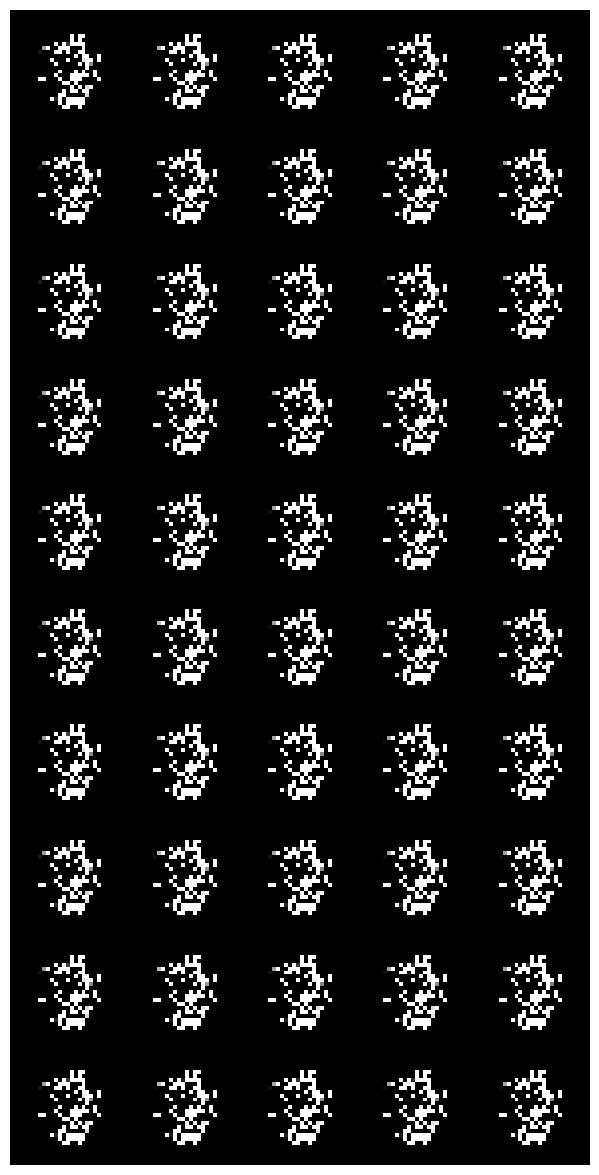

In [8]:
plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(inter_results[0])

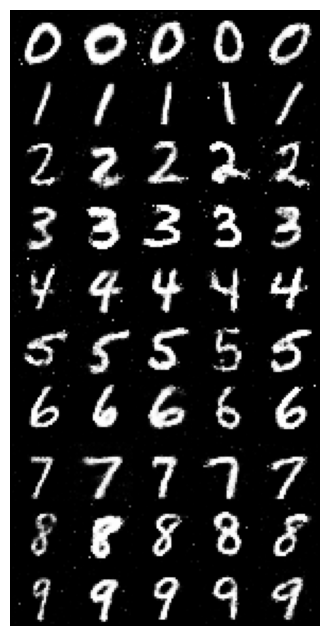

In [9]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(i, animated=True)] for i in inter_results]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())